# Design of an LQG controller for cartpole gym environment

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control
import gym
import gym_CartPole_BT
from gym_CartPole_BT.systems.cartpend import cartpend_ss
from env_utils import simulation_rollout, simulation_rollouts
from control_baselines import LQR, LQRCartPend, LQGCartPend

In [3]:
list(gym_CartPole_BT.env_configs.keys())

['CartPole-BT-v0',
 'CartPole-BT-dL-v0',
 'CartPole-BT-dH-v0',
 'CartPole-BT-vL-v0',
 'CartPole-BT-vH-v0',
 'CartPole-BT-dL-vL-v0',
 'CartPole-BT-dH-vH-v0',
 'CartPole-BT-p2-v0',
 'CartPole-BT-p2-dL-v0',
 'CartPole-BT-p2-dH-v0',
 'CartPole-BT-p2-vL-v0',
 'CartPole-BT-p2-vH-v0',
 'CartPole-BT-x2-v0',
 'CartPole-BT-x2-dL-v0',
 'CartPole-BT-x2-dH-v0']

In [4]:
env = gym.make('CartPole-BT-dH-v0')

In [5]:
# Get continuous time state-space matrices for linearized
# model of cart-pendulum system in vertiacal up position:
A, B = cartpend_ss()
C = env.output_matrix
D = np.array([[ 0. ],
              [ 0. ],
              [ 0. ],
              [ 0. ]], dtype='float32')
[a.shape for a in [A, B, C, D]]

[(4, 4), (4, 1), (4, 4), (4, 1)]

In [6]:
Gcss = control.ss(A, B, C, D)
Gcss

StateSpace(array([[ 0. ,  1. ,  0. ,  0. ],
       [ 0. , -0.2,  2. ,  0. ],
       [ 0. ,  0. ,  0. ,  1. ],
       [ 0. , -0.1,  6. ,  0. ]]), array([[0. ],
       [0.2],
       [0. ],
       [0.1]]), array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), array([[0.],
       [0.],
       [0.],
       [0.]]))

In [7]:
# Sample period
Ts = env.env.tau
Ts

0.05

In [8]:
env.disturbances

'high'

In [9]:
# This is actually the std. dev. of the random noise
env.variance_levels[env.disturbances] ** 2

0.04000000000000001

In [10]:
# Disturbance is applied to state 3 as follows (see cartpole_bt_env.py):
# v = self.variance_levels[self.disturbances]
# self.state[3] += 0.05 * self.np_random.normal(scale=v)

In [11]:
from control import lqr

In [12]:
help(lqr)

Help on function lqr in module control.statefbk:

lqr(*args, **keywords)
    lqr(A, B, Q, R[, N])
    
    Linear quadratic regulator design
    
    The lqr() function computes the optimal state feedback controller
    that minimizes the quadratic cost
    
    .. math:: J = \int_0^\infty (x' Q x + u' R u + 2 x' N u) dt
    
    The function can be called with either 3, 4, or 5 arguments:
    
    * ``lqr(sys, Q, R)``
    * ``lqr(sys, Q, R, N)``
    * ``lqr(A, B, Q, R)``
    * ``lqr(A, B, Q, R, N)``
    
    where `sys` is an `LTI` object, and `A`, `B`, `Q`, `R`, and `N` are
    2d arrays or matrices of appropriate dimension.
    
    Parameters
    ----------
    A, B : 2D array
        Dynamics and input matrices
    sys : LTI (StateSpace or TransferFunction)
        Linear I/O system
    Q, R : 2D array
        State and input weight matrices
    N : 2D array, optional
        Cross weight matrix
    
    Returns
    -------
    K : 2D array (or matrix)
        State feedback gains

In [21]:
Q = np.diag([1, 5, 10, 10])
#Q = np.eye(4)
R = 0.1
K, S, E = lqr(A, B, Q, R)
K.round(4)

array([[ -3.1623, -13.1358, 212.228 ,  90.7702]])

## LQR Simulation tests

In [13]:
env = gym.make('CartPole-BT-dH-v0')

In [14]:
# Initialize linear model
#lqr_gain = np.array([[ -3.1623, -13.1358, 212.228 ,  90.7702]])
#lqr_gain = np.array([[ -1.    ,  -6.0753, 158.7933,  66.4522]])
#lqr_gain = np.array([[-10.    , -34.8584, 382.6953, 168.9981]])
#lqr_gain = np.array([[-100.00,   -197.54,   1491.28,    668.44]])  # From test_run_lqr.py
#lqr_gain = np.array([[-100.    , -321.3686, 2691.7527, 1232.2092]])
#lqr_gain = np.array([[-31.6228, -66.2074, 574.0288, 253.7828]])
lqr_gain = np.array([[-100.    , -197.5366, 1491.2808,  668.4449]])
    
model = LQRCartPend(None, env, gain=lqr_gain)
model.gain

array([[-100.    , -197.5366, 1491.2808,  668.4449]], dtype=float32)

In [15]:
lqr_gain, Q, R

(array([[-100.    , -197.5366, 1491.2808,  668.4449]]),
 array([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]]),
 0.0001)

In [16]:
trajectory = simulation_rollout(env, model, n_steps=None, 
                                log=False, render=False)
out = np.array(trajectory, dtype=object)
out.shape

(100, 3)

Avg. cum reward: -0.591


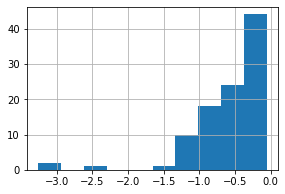

In [17]:
n_repeats = 100
states, actions, rewards = simulation_rollouts(env, model, n_steps=None, n_repeats=n_repeats, 
                                               log=True, render=False)
assert(states.shape == (n_repeats, 100, 4))
assert(actions.shape == (n_repeats, 100, 1))
assert(rewards.shape == (n_repeats, 100))

cum_rewards = np.sum(rewards, axis=1)
print(f"Avg. cum reward: {np.mean(cum_rewards):0.3f}")
pd.Series(cum_rewards).hist(figsize=(4.5, 3))
plt.show()

## Kalman filter design

In [18]:
env = gym.make('CartPole-BT-p2-vH-v0')

In [19]:
# Get continuous time state-space matrices for linearized
# model of cart-pendulum system in vertiacal up position:
A, B = cartpend_ss()
C = env.output_matrix
D = np.array([[ 0. ],
              [ 0. ]], dtype='float32')
[a.shape for a in [A, B, C, D]]

[(4, 4), (4, 1), (2, 4), (2, 1)]

In [20]:
# Construct continous time state space model
Gcss = control.ss(A, B, C, D)
Gcss

StateSpace(array([[ 0. ,  1. ,  0. ,  0. ],
       [ 0. , -0.2,  2. ,  0. ],
       [ 0. ,  0. ,  0. ,  1. ],
       [ 0. , -0.1,  6. ,  0. ]]), array([[0. ],
       [0.2],
       [0. ],
       [0.1]]), array([[1., 0., 0., 0.],
       [0., 0., 1., 0.]]), array([[0.],
       [0.]]))

In [21]:
# Convert to discrete-time model
Gdss = control.c2d(Gcss, env.tau)
Gdss

StateSpace(array([[ 1.00000000e+00,  4.97507794e-02,  2.49480674e-03,
         4.15939085e-05],
       [ 0.00000000e+00,  9.90045685e-01,  9.97511222e-02,
         2.49480674e-03],
       [ 0.00000000e+00, -1.24740337e-04,  1.00750522e+00,
         5.01250418e-02],
       [ 0.00000000e+00, -4.98755611e-03,  3.00500770e-01,
         1.00750522e+00]]), array([[0.00024922],
       [0.00995432],
       [0.00012474],
       [0.00498756]]), array([[1., 0., 0., 0.],
       [0., 0., 1., 0.]]), array([[0.],
       [0.]]), 0.05)

In [22]:
KF = {
    'A': Gdss.A,
    'B': Gdss.B,
    'C': Gdss.C,
    'D': Gdss.D
}
KF

{'A': array([[ 1.00000000e+00,  4.97507794e-02,  2.49480674e-03,
          4.15939085e-05],
        [ 0.00000000e+00,  9.90045685e-01,  9.97511222e-02,
          2.49480674e-03],
        [ 0.00000000e+00, -1.24740337e-04,  1.00750522e+00,
          5.01250418e-02],
        [ 0.00000000e+00, -4.98755611e-03,  3.00500770e-01,
          1.00750522e+00]]),
 'B': array([[0.00024922],
        [0.00995432],
        [0.00012474],
        [0.00498756]]),
 'C': array([[1., 0., 0., 0.],
        [0., 0., 1., 0.]]),
 'D': array([[0.],
        [0.]])}

In [23]:
# Solving discrete algebraic Riccati equation
# In MATLAB
# [X,K,L] = idare(A,B,Q,R,S,E) computes the stabilizing solution X of
#     the discrete-time algebraic Riccati equation
#                                          -1 
#        E'XE = A'XA - (A'XB + S)(B'XB + R)  (A'XB + S)' + Q
#  
#     The matrices Q,R must be Hermitian and E must be nonsingular. When 
#     omitted or set to [], R,S,E default to the values R=I, S=0, E=I. 
#     Scalar-valued Q,R are interpreted as multiples of the identity matrix. 
#     idare also returns the state-feedback gain K and the closed-loop
#     eigenvalues L given by
#                      -1
#        K = (B'XB + R)  (B'XA + S'),    L = EIG(A-B*K,E) .
# 
# Example from GEL-7029, exercise 12.3:
#  A = 0.8; B = 2; C = 0.5; Q = 0.3; R = 1.1;
# [X,K,L,info] = idare(A,C',Q,R,[],[]);
# X = 0.6741
# In Python:
# A = np.array([[0.8]]); C = np.array([[0.5]]); Q = np.array([[0.3]]); R = np.array([[1.1]]);
# X, L, G = control.dare(A.T, C.T, Q, R)
# assert(X.round(4) == 0.6741)

In [24]:
help(control.dare)

Help on function dare in module control.mateqn:

dare(A, B, Q, R, S=None, E=None, stabilizing=True)
    (X, L, G) = dare(A, B, Q, R) solves the discrete-time algebraic Riccati
    equation
    
        :math:`A^T X A - X - A^T X B (B^T X B + R)^{-1} B^T X A + Q = 0`
    
    where A and Q are square matrices of the same dimension. Further, Q
    is a symmetric matrix. The function returns the solution X, the gain
    matrix G = (B^T X B + R)^-1 B^T X A and the closed loop eigenvalues L,
    i.e., the eigenvalues of A - B G.
    
    (X, L, G) = dare(A, B, Q, R, S, E) solves the generalized discrete-time
    algebraic Riccati equation
    
        :math:`A^T X A - E^T X E - (A^T X B + S) (B^T X B + R)^{-1} (B^T X A + S^T) + Q = 0`
    
    where A, Q and E are square matrices of the same dimension. Further, Q and
    R are symmetric matrices. The function returns the solution X, the gain
    matrix :math:`G = (B^T X B + R)^{-1} (B^T X A + S^T)` and the closed loop
    eigenvalues L, i.e

In [25]:
# Compute discrete-time Kalman filter gain matrix
Q = np.eye(4)
R = 0.01**2*np.eye(2)
X, L, G = control.dare(KF['A'].T, KF['C'].T, Q, R)
P = X
K = G.T
print(K)
print(L.round(2))

[[ 1.03962720e+00  2.07302137e-03]
 [ 7.90472757e-01  9.32428877e-02]
 [-7.72253147e-04  1.06420691e+00]
 [-1.75014331e-02  1.44210117e+00]]
[0.95+0.j 0.95-0.j 0.  +0.j 0.  +0.j]


In [26]:
# Poles
L

array([9.50511398e-01+0.00349618j, 9.50511398e-01-0.00349618j,
       9.99800383e-05+0.j        , 9.92342699e-05+0.j        ])

In [27]:
# Computed in MATLAB:
kf_gain_ML = """
    1.0396    0.0021
    0.7905    0.0932
   -0.0008    1.0642
   -0.0175    1.4421
"""
kf_gain_ML = np.fromstring(kf_gain_ML, dtype='float32', sep=' ', count=8).reshape(4, 2)
assert(np.isclose(K, kf_gain_ML, atol=1e-03).all())

## LQG Simulation tests

In [28]:
import control_baselines
from importlib import reload
reload(control_baselines)
from control_baselines import LQR, LQRCartPend, LQGCartPend 

In [29]:
env = gym.make('CartPole-BT-p2-vH-v0')

In [30]:
# Initialize linear model
#lqr_gain = np.array([[ -3.1623, -13.1358, 212.228 ,  90.7702]])
#lqr_gain = np.array([[ -1.    ,  -6.0753, 158.7933,  66.4522]])
#lqr_gain = np.array([[-10.    , -34.8584, 382.6953, 168.9981]])
#lqr_gain = np.array([[-100.00,   -197.54,   1491.28,    668.44]])  # From test_run_lqr.py
#lqr_gain = np.array([[-100.    , -321.3686, 2691.7527, 1232.2092]])
#lqr_gain = np.array([[-31.6228, -66.2074, 574.0288, 253.7828]])
lqr_gain = np.array([[-100.    , -197.5366, 1491.2808,  668.4449]])

model = LQGCartPend(None, env, gain=lqr_gain)

In [31]:
model.gain

array([[-100.    , -197.5366, 1491.2808,  668.4449]], dtype=float32)

In [32]:
model.kf_gain

array([[1.03698023, 0.09272008],
       [0.74619911, 3.13279722],
       [0.02786013, 1.11201979],
       [0.56180153, 3.01500955]])

In [33]:
Gcss = control.ss(A, B, C, D)
Gdss = control.c2d(Gcss, env.tau)
A = Gdss.A
B = Gdss.B
C = Gdss.C
D = Gdss.D

In [34]:
Q = 0.1**2 * np.eye(4)
R = 0.001**2 * np.eye(2)

In [35]:
X, L, G = control.dare(A.T, C.T, Q, R)
P = X.T
kf_gain = G.T

In [36]:
kf_gain

array([[ 1.03962720e+00,  2.07302137e-03],
       [ 7.90472757e-01,  9.32428877e-02],
       [-7.72253147e-04,  1.06420691e+00],
       [-1.75014331e-02,  1.44210117e+00]])

In [37]:
model.x_est

array([[0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [38]:
assert(model.A.shape == (4, 4))
assert(model.B.shape == (4, 1))
assert(model.C.shape == (2, 4))
assert(model.D.shape == (2, 1))

In [39]:
assert(model.x_est.shape == (4, 1))

In [40]:
model.u

array([0.])

In [41]:
self = model
-self.gain @ self.x_est

array([[0.]], dtype=float32)

In [42]:
observation = env.reset()
observation.reshape(2, 1)

array([[-0.24214813],
       [ 3.376036  ]], dtype=float32)

In [43]:
self.env.goal_state

array([0.       , 0.       , 3.1415927, 0.       ], dtype=float32)

In [44]:
ym = observation.reshape(2, 1) - self.C @ self.env.goal_state.reshape(4, 1)
ym

array([[-0.24214813],
       [ 0.23444319]], dtype=float32)

In [45]:
error = ym - self.C @ self.x_est
error

array([[-0.24214813],
       [ 0.23444319]], dtype=float32)

In [46]:
self.A @ self.x_est + self.B @ self.u.reshape(-1, 1) + self.kf_gain @ error

array([[-0.22936523],
       [ 0.55377225],
       [ 0.25395919],
       [ 0.57080926]])

In [47]:
model.predict(observation)

(array([0.]), None)

In [48]:
trajectory = simulation_rollout(env, model, n_steps=None, 
                                log=False, render=False)
out = np.array(trajectory, dtype=object)
out.shape

(100, 3)

In [49]:
observation = env.reset()

lqr_gain = np.array([[-100.    , -197.5366, 1491.2808,  668.4449]])
model = LQGCartPend(None, env, gain=lqr_gain)

model.gain

array([[-100.    , -197.5366, 1491.2808,  668.4449]], dtype=float32)

In [50]:
# TODO: This is not the same as test_run_lqg.py
model.kf_gain

array([[1.03698023, 0.09272008],
       [0.74619911, 3.13279722],
       [0.02786013, 1.11201979],
       [0.56180153, 3.01500955]])

In [51]:
# Control vector (shape (1, ) in this case)
u = np.zeros(1)

cum_reward = 0.0

print(f"{'k':>3s}  {'u':>5s} {'reward':>6s} {'cum_reward':>10s}")
print("-"*28)

# Run one episode
done = False
while not done:

    # Linear quadratic regulator
    # u[t] = -Ky[t]
    u[:] = model.predict(observation)[0]

    # Run simulation one time-step
    observation, reward, done, info = env.step(u)

    # Update the animation
    #env.render()

    # Process the reward
    cum_reward += reward

    # Print updates
    print(f"{env.time_step:3d}: {u[0]:5.1f} {reward:6.2f} "
          f"{cum_reward:10.1f}")


  k      u reward cum_reward
----------------------------
  1:   0.0  -0.03       -0.0
  2: 351.3  -0.03       -0.1
  3: -46315.3  -0.04       -0.1
  4: 6158360.9  -0.06       -0.2
  5: -819173558.1  -0.07       -0.2
  6: 108966602798.9  -0.09       -0.3
  7: -14494763972015.1  -0.12       -0.4
  8: 1928097066082983.0  -0.14       -0.6
  9: -256475945827381824.0  -0.17       -0.8
 10: 34116493379506774016.0  -0.20       -1.0
 11: -4538184338341986566144.0  -0.23       -1.2
 12: 603670396593119185338368.0  -0.27       -1.5
 13: -80300384593022823568506880.0  -0.30       -1.8
 14: 10681576903850576239424176128.0  -0.34       -2.1
 15: -1420865986273092637750865166336.0  -0.39       -2.5
 16: 189003942874767357505265293328384.0  -0.43       -2.9
 17: -25141350955910926393133745949376512.0  -0.48       -3.4
 18: 3344308686232538209805821600382058496.0  -0.53       -3.9
 19: -444860763784090222563105250449758879744.0  -0.59       -4.5
 20: 59175488186620018795572324560653831372800.0  -0.65 

In [52]:
n_repeats = 100
observations, actions, rewards = simulation_rollouts(env, model, n_steps=None, n_repeats=n_repeats, 
                                               log=True, render=False)
assert(observations.shape == (n_repeats, 100, 2))
assert(actions.shape == (n_repeats, 100, 1))
assert(rewards.shape == (n_repeats, 100))

cum_rewards = np.sum(rewards, axis=1)
print(f"Avg. cum reward: {np.mean(cum_rewards):0.3f}")
pd.Series(cum_rewards).hist(figsize=(4.5, 3))
plt.show()

/Users/billtubbs/testing-rl/control_baselines.py:233: RuntimeWarning: overflow encountered in matmul
  self.u[:] = -self.gain @ self.x_est
/Users/billtubbs/testing-rl/control_baselines.py:233: RuntimeWarning: invalid value encountered in matmul
  self.u[:] = -self.gain @ self.x_est


KeyboardInterrupt: 

> /anaconda3/envs/torch/lib/python3.9/site-packages/scipy/integrate/_ivp/rk.py(136)_step_impl()
    134 
    135             h = h_abs * self.direction
--> 136             t_new = t + h
    137 
    138             if self.direction * (t_new - self.t_bound) > 0:

--KeyboardInterrupt--
ipdb> q


In [ ]:
cum_rewards = np.sum(rewards, axis=1)
print(f"Avg. cum reward: {np.mean(cum_rewards):0.3f}")
pd.Series(cum_rewards).hist(figsize=(4.5, 3))
plt.show()